## Program for preparing labeled data from label box

In [2]:
# Import necessary packages
import numpy as np
import json
import sys
#download tool for http requests
!conda install --yes --prefix {sys.prefix} requests
import requests
import imageio

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.4
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/michael/anaconda3/envs/test

  added / updated specs:
    - requests


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cffi-1.12.3                |   py37h2e261b9_0         222 KB
    cryptography-2.6.1         |   py37h1ba5d50_0         616 KB
    pyopenssl-19.0.0           |           py37_0          82 KB
    pysocks-1.7.0              |           py37_0          29 KB
    urllib3-1.24.2             |           py37_0         153 KB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  asn1crypto         pk

### Get the data from the json file pointed to by the filepath below

In [250]:
# read the command line input for the path to the json file with labels
filepath = "export-2019-05-26T19_32_50.493Z.json"

mask_img = []
img = []
with open(filepath, "r") as read_file:
    data = json.load(read_file)
    string = json.dumps(data, indent=2)
    # print(string) # for visualizing the json better
    i = 0
    for item in data:
        masks = item['Masks']
        
        for layer in masks:
            url = masks[layer]
            im = imageio.imread(url)
            try:
                mask_img[i].append(im[:, :, 0])
            except:
                mask_img.append([])
                mask_img[i].append(im[:, :, 0])
            
        image_url = item['Labeled Data']
        img.append(imageio.imread(image_url))
        i+=1


In [306]:
#Turn mask_images into a numpy array
images = np.array(img)
mask_images = np.array(mask_img)
print(mask_images.shape)

(1, 3, 1653, 2480)


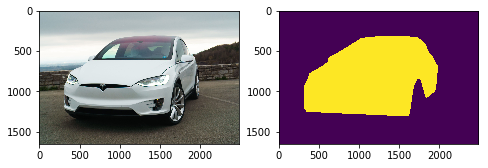

In [307]:
#Make sure that data was collected ok

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#view the results of the test
fig=plt.figure(figsize=(25, 25))
for i in range(len(images)):
                
    fig.add_subplot(5, 6, i+1)
    plt.imshow(images[i])
    fig.add_subplot(5, 6, i+2) #first mask of every image
    plt.imshow(mask_images[i, 0])
    
    
plt.show()

In [308]:
#Concatenate the masks into a single high channel array and turn array values from 0-255 to 0-1
mask_images = np.moveaxis(mask_images, 1, 3)
mask_images = mask_images/255.0
print(mask_images.shape)

(1, 1653, 2480, 3)


In [310]:
#resize images
import skimage.transform as trans

target_size = (512,512)

images_resized = np.zeros((len(images),target_size[0],target_size[1],3))
mask_images_resized = np.zeros((len(images),target_size[0],target_size[1],(len(mask_images[0,0,0]))))

print(images.shape)
print(mask_images.shape)

for i in range(len(images)):
    images_resized[i] = trans.resize(images[i],target_size)
    mask_images_resized[i] = trans.resize(mask_images[i],target_size)
    
print(images_resized.shape)
print(mask_images_resized.shape)

(1, 1653, 2480, 3)
(1, 1653, 2480, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


1.0


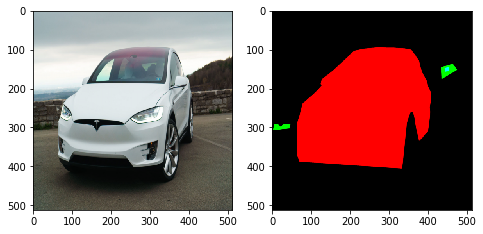

In [311]:
#Make sure that data is transformed ok

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ind = np.unravel_index(np.argmax(mask_images, axis=None), mask_images.shape)
print(mask_images[ind]) #make sure that the image has been converted to range 0.0-1.0

#view the results of the test
fig=plt.figure(figsize=(25, 25))
for i in range(len(images_resized)):
                
    fig.add_subplot(5, 6, i+1)
    plt.imshow(images_resized[i])
    fig.add_subplot(5, 6, i+2) #first mask of every image
    plt.imshow(mask_images_resized[i], vmin=0, vmax=1)
    #plt.imshow(mask_images_resized[i,:,:,0], cmap='gray', vmin=0, vmax=1)

    
plt.show()

In [312]:
#save the images and their masks
import os
import random #generate distribution to assign 80% of images to train and 20% to test

os.makedirs("train", exist_ok=True)
os.makedirs("test", exist_ok=True)

for i in range(len(images_resized)):
    if(random.randint(1,101) < 80):
        imageio.imwrite("train/" + str(i) + '.jpg', images_resized[i])
        imageio.imwrite("train/" + str(i) + '_mask.jpg', mask_images_resized[i])
    else:
        imageio.imwrite("test/" + str(i) + '.jpg', images_resized[i])
        imageio.imwrite("test/" + str(i) + '_mask.jpg', mask_images_resized[i])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
